# ripe or rotten mango?

Se instalan e importan librerías para datos, preprocesamiento, visualización y modelos.

In [1]:
%reload_ext autoreload
%autoreload 2
# %pip install -q -r ../requirements.txt --user

from IPython.core.display import HTML, Markdown
display(HTML("<style>td { white-space: nowrap; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import sys
sys.path.append('../')  

import pandas as pd 
from src.data import get_dataset, preprocess, graphic

### **Descripción del Problema**

Este proyecto trata de un problema de aprendizaje supervisado, donde el objetivo es clasificar imágenes de mangos en dos categorías: Ripe (maduro) y Rotten (podrido). Utilizando un conjunto de datos con etiquetas conocidas, el modelo aprenderá a identificar y clasificar nuevas imágenes en función de las características visuales que permitan distinguir entre ambas clases. El conjunto de datos utilizado proviene de [Kaggle](https://www.kaggle.com/datasets/adrinbd/unripe-ripe-rotten-mango) y contiene imágenes tomadas bajo diferentes condiciones de iluminación y fondos variados.

Este conjunto de datos consta de un total de 2,741 imágenes de mangos, que están etiquetadas en tres categorías: **Ripe**, **Unripe** (no maduro) y **Rotten**. Para esta implementación, nos enfocaremos exclusivamente en las 2,100 imágenes correspondientes a las categorías Ripe y Rotten, las cuales se dividen de la siguiente manera:

- **1,989 imágenes** para el conjunto de entrenamiento.
- **211 imágenes** para el conjunto de validación.

Cabe destacar que el conjunto de datos solo incluye las etiquetas de clase (Ripe o Rotten) asociadas a cada imagen, por lo que será necesario extraer características adicionales a partir de las imágenes mismas para poder entrenar el modelo de manera efectiva.

Se utilizará la clase `kagglehub` para descargar y cargar los conjuntos de entrenamiento y validación, generando archivos `.csv` que contienen los nombres y etiquetas de las imágenes, lo que facilitará su manejo para el preprocesamiento y entrenamiento del modelo.

Loaded 'raw\train' in 0.02s | 1989 rows, 2 cols
Loaded 'raw\validation' in 0.01s | 211 rows, 2 cols


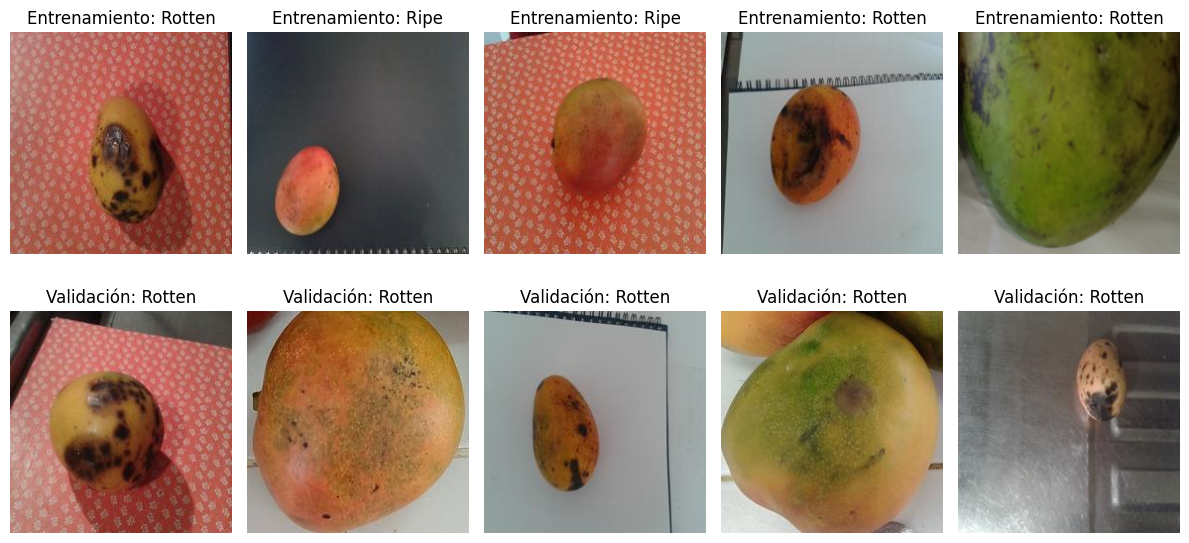

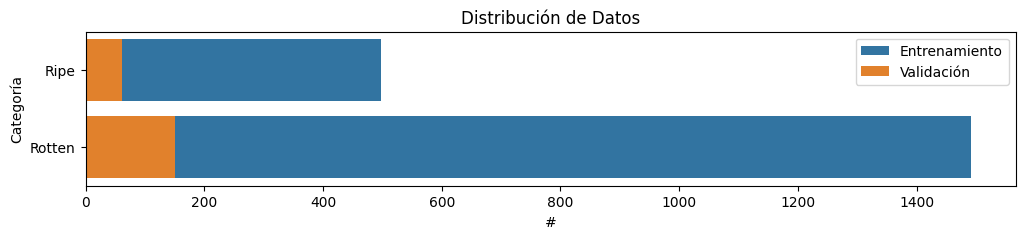

In [2]:
dataset = get_dataset()
graphic.show_dataset(dataset.train_data, dataset.validation_data)
graphic.show_data_distribution(dataset.train_data, dataset.validation_data)

### **Preprocesamiento**

Para preparar las imágenes de mangos para una clasificación efectiva, se implementaron diversas estrategias, considerando las características y necesidades del conjunto de datos:

#### Conversión de Variables

El conjunto de datos incluye imágenes de mangos clasificadas en dos categorías: Ripe (maduro) y Rotten (podrido). Para facilitar el trabajo con modelos de clasificación, se realizó una codificación binaria de las etiquetas, asignando el valor **0** a Ripe y **1** a Rotten. Este proceso se lleva a cabo mediante el uso de la clase `LabelEncoder` (sklearn), que convierte las etiquetas categóricas en valores numéricos, haciéndolas compatibles con los modelos de aprendizaje automático.

In [3]:
labels = dataset.get_labels()
print(f"Labels: {set(labels['train'])}")

Labels: {np.int64(0), np.int64(1)}


#### Selección de Características

Se extrajeron diversas características relevantes de las imágenes:

- Estadísticas de los canales RGB (media y desviación estándar).
- Histogramas de intensidad en los canales RGB.
- Características de textura de Haralick (entropía, homogeneidad, contraste, correlación).

 Para asegurar que las diferencias en la escala de las características no afectaran negativamente el rendimiento del modelo, se aplicó un `MinMaxScaler`, escalando todas las características al rango [0, 1], lo cual favoreció la convergencia y el desempeño de los algoritmos de aprendizaje automático. 
 
 Las bibliotecas utilizadas para la extracción de características incluyen `cv2` (opencv) para el procesamiento de imágenes, `numpy` para cálculos estadísticos y operaciones numéricas, pandas para manejo de datos estructurados, y `skimage` para calcular características de textura mediante la matriz de co-ocurrencia de niveles de gris (GLCM), que permite extraer propiedades como contraste, correlación, energía y homogeneidad.

In [4]:
preprocessor = preprocess(dataset)
train_data = pd.DataFrame(preprocessor.train_data)
validation_data = pd.DataFrame(preprocessor.validation_data)
train_data.describe()

Loaded 'processed\train' in 2.76s | 1989 rows, 778 cols
Loaded 'processed\validation' in 0.30s | 211 rows, 778 cols


,mean_r,mean_g,mean_b,std_dev_r,std_dev_g,std_dev_b,hist_0,hist_1,hist_2,hist_3,...,hist_762,hist_763,hist_764,hist_765,hist_766,hist_767,texture_contrast,texture_correlation,texture_energy,texture_homogeneity
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,...,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,0.446132,0.344431,0.354143,0.390322,0.291441,0.329092,0.005064,0.007870,0.008349,0.010582,...,0.028082,0.003139,0.003909,0.004746,0.005924,0.021726,0.069757,0.861402,0.083771,0.491656
std,0.157576,0.143841,0.153833,0.177011,0.151412,0.170014,0.029179,0.037776,0.040730,0.044865,...,0.087092,0.028906,0.024761,0.032238,0.033447,0.110285,0.075534,0.161573,0.113562,0.265662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.342427,0.246236,0.252062,0.273051,0.179727,0.198023,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020179,0.817522,0.022223,0.285310
50%,0.448688,0.318214,0.323236,0.385831,0.271099,0.324202,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053437,0.923070,0.036477,0.434306
75%,0.549893,0.438036,0.459183,0.502856,0.387281,0.433245,0.000000,0.000000,0.000504,0.000495,...,0.004947,0.000369,0.000368,0.000428,0.000082,0.000323,0.093573,0.968414,0.119930,0.765083
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Reducción de Dimensionalidad

Para reducir la dimensionalidad y evitar el sobreajuste, se aplicó **Análisis de Componentes Principales (PCA)**, manteniendo el **95% de la varianza** en el conjunto de entrenamiento. Este paso ayudó a eliminar redundancias y a preservar la mayor cantidad posible de información relevante, mejorando así la eficiencia computacional. El `PCA` (sklearn) reduce la dimensionalidad transformando los datos en un menor número de componentes, al tiempo que conserva la varianza, lo que facilita el procesamiento y mejora el rendimiento de los modelos de aprendizaje automático.

In [5]:
preprocessor.apply_pca(n_components=0.95)
train_pca = pd.DataFrame(preprocessor.train_pca)
validation_pca = pd.DataFrame(preprocessor.validation_pca)
train_pca.describe()

PCA components: 86


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
count,1.989000e+03,1.989000e+03,1989.000000,1.989000e+03,1989.000000,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,...,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03
mean,-3.572362e-17,-1.428945e-17,0.000000,-3.572362e-17,0.000000,-7.144723e-18,2.143417e-17,-1.875490e-17,1.786181e-17,8.930904e-18,...,1.596399e-17,-5.135270e-18,1.384290e-17,1.116363e-18,1.161018e-17,2.366690e-17,-5.693451e-18,-9.349540e-18,2.902544e-18,-4.465452e-18
std,1.166260e+00,1.034568e+00,0.848130,7.759170e-01,0.680932,5.681931e-01,5.163888e-01,4.686866e-01,4.277407e-01,4.134202e-01,...,8.520634e-02,8.427532e-02,8.358817e-02,8.294036e-02,8.119783e-02,8.099004e-02,8.057328e-02,7.920159e-02,7.860996e-02,7.750198e-02
min,-2.607793e+00,-2.629408e+00,-2.046576,-2.213567e+00,-3.173307,-2.096863e+00,-1.884857e+00,-1.873200e+00,-1.936301e+00,-1.465704e+00,...,-4.952147e-01,-9.431862e-01,-7.790937e-01,-5.149739e-01,-3.833461e-01,-4.052277e-01,-5.879065e-01,-3.697691e-01,-3.776711e-01,-4.712832e-01
25%,-5.451725e-01,-7.356239e-01,-0.569507,-3.397343e-01,-0.401653,-2.839983e-01,-2.107120e-01,-2.458486e-01,-2.331285e-01,-2.258335e-01,...,-3.881367e-02,-3.548452e-02,-4.484114e-02,-3.443655e-02,-4.535113e-02,-4.635042e-02,-3.374185e-02,-3.561060e-02,-3.751458e-02,-3.333989e-02
50%,-1.232276e-01,3.338507e-01,-0.074228,8.103757e-02,-0.045612,-3.895632e-02,-1.011398e-02,5.065509e-03,-2.611116e-02,-2.125084e-02,...,1.263298e-03,-3.924493e-04,-3.878306e-03,-3.366552e-03,-1.400808e-03,-4.321262e-03,6.546125e-04,1.355332e-03,-2.615755e-03,-2.510054e-03
75%,2.164254e-01,7.801271e-01,0.575656,4.186674e-01,0.324997,2.487062e-01,2.102333e-01,2.582376e-01,2.008991e-01,1.992605e-01,...,4.098621e-02,4.097408e-02,4.091995e-02,3.444427e-02,4.370435e-02,4.419246e-02,3.051308e-02,3.611054e-02,3.641719e-02,3.195712e-02
max,3.157889e+00,2.204431e+00,3.098797,3.059541e+00,2.266834,2.368505e+00,3.512741e+00,2.096209e+00,3.171087e+00,1.719458e+00,...,5.320674e-01,4.479684e-01,4.838426e-01,8.291061e-01,4.069765e-01,4.662503e-01,6.009892e-01,3.760088e-01,3.666062e-01,4.683470e-01


#### Balanceo del Dataset

Dado que el conjunto original estaba desbalanceado (con más muestras de Rotten), se aplicarán **class weights** durante el entrenamiento. Esto asigna un mayor peso a la clase minoritaria (Ripe), ayudando al modelo a enfocarse de manera más equilibrada en ambas clases.

In [6]:
class_weight = dataset.get_weights()
print(f"Class weights: Ripe {class_weight[0]:.2f}, Rotten {class_weight[1]:.2f}")

Class weights: Ripe 2.00, Rotten 0.67


#### Vectorización de los Datos

Las características extraídas fueron organizadas en archivos `CSV` y `DataFrames`, con cada fila representando una imagen y cada columna conteniendo los valores de las características correspondientes. Este formato facilitó la conversión de los datos para su procesamiento y análisis con modelos de machine learning.

Estas estrategias de preprocesamiento permiten optimizar los datos para la construcción de modelos de clasificación, mejorando tanto la eficiencia computacional como el rendimiento general del modelo.

### **Visualización**

Para explorar las características del conjunto de datos, se utilizaron diversas herramientas de visualización:

- **Procesamiento de imágenes**: Se emplearon `PIL` (Pillow) y `numpy` para el manejo de imágenes, su redimensionamiento y la extracción de histogramas.
- **Análisis de datos**: `pandas` se utilizó para gestionar los conjuntos de datos, mientras que numpy apoyó en las operaciones numéricas.
- **Visualización**: `matplotlib` y `seaborn` se utilizaron para crear diversos gráficos que permiten visualizar distribuciones del conjunto de datos, histogramas de imágenes, resultados de PCA, matrices de confusión y el rendimiento del modelo.

Estas visualizaciones buscan proporcionar una visión clara de la estructura de los datos, lo que ayuda a identificar patrones, correlaciones y posibles problemas antes de entrenar el modelo.

#### Muestras Aleatorias y sus Histogramas RGB

Se mostraron imágenes aleatorias del conjunto de entrenamiento junto con sus histogramas de los canales RGB, lo que permitió observar cómo se distribuyen las intensidades de color en cada imagen.

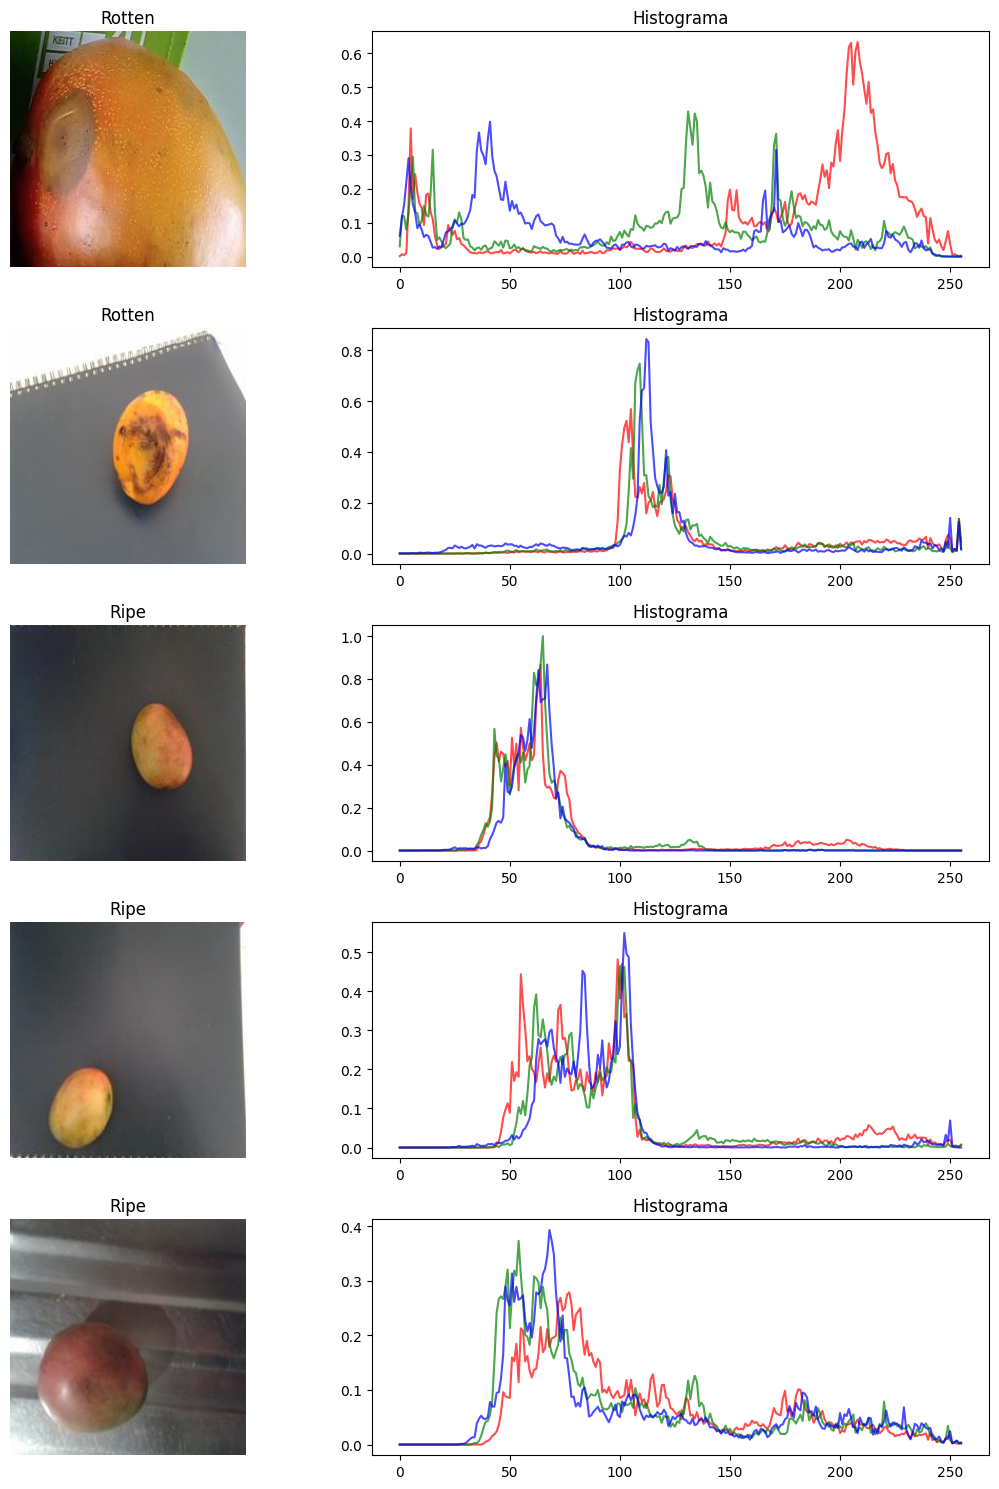

In [7]:
images = pd.DataFrame(dataset.train_data)
graphic.show_samples(images, train_data, num_samples=5)

#### Análisis de Estadísticas RGB y Correlación  

Se analizaron las distribuciones de la media y desviación estándar de los canales RGB mediante histogramas, observando cómo varían estas características en el conjunto de datos. Además, se presentó una matriz de correlación para entender las relaciones entre las características de los canales RGB, lo que facilitó la identificación de posibles relaciones.

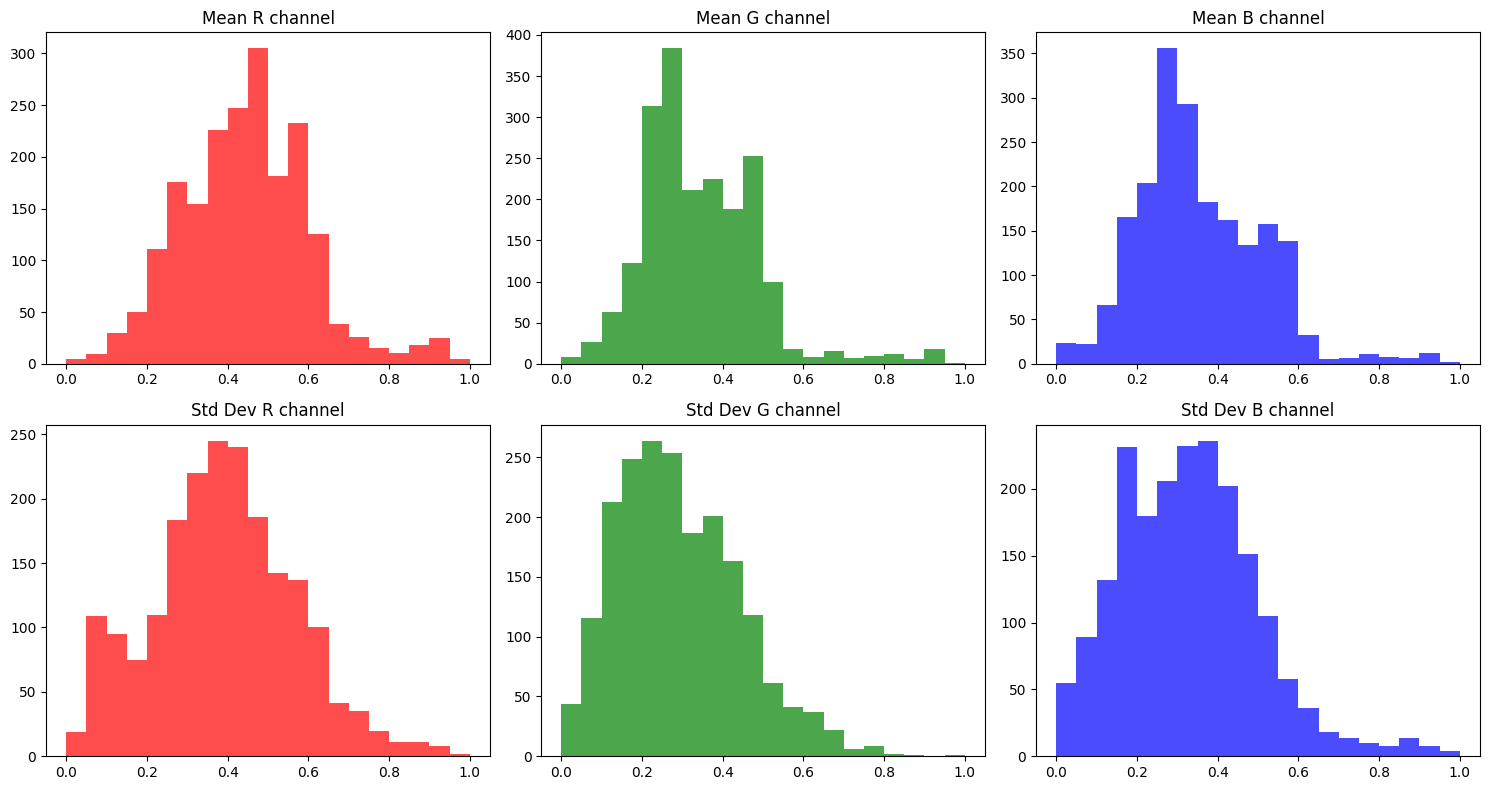

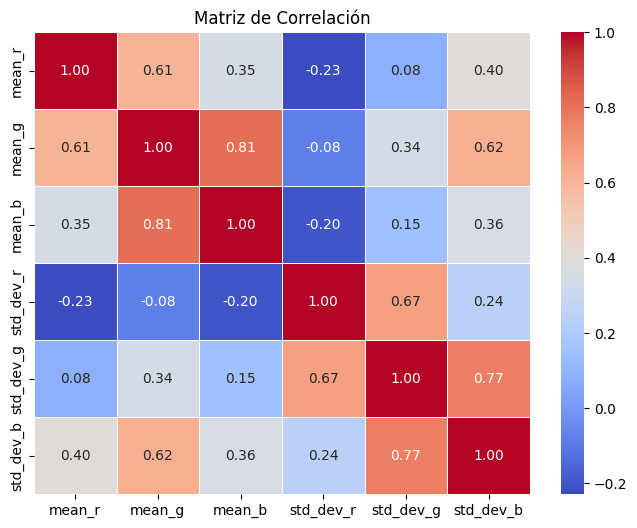

In [8]:
stats_key = ["mean_r", "mean_g", "mean_b", "std_dev_r", "std_dev_g", "std_dev_b"]
stats = train_data[stats_key]

graphic.show_channels(stats)
graphic.show_correlation(stats)

#### Diagrama de dispersión de PCA

Se aplicó PCA para reducir la dimensionalidad y se visualizó la separación de las clases Ripe y Rotten en el espacio reducido, evaluando la efectividad de la reducción de características.

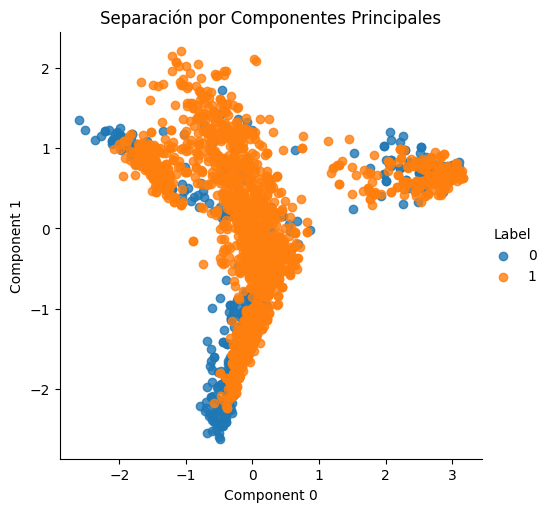

In [9]:
graphic.show_pca(train_pca, labels["train"])

### **Modelos de predicción**

En este análisis, se entrenarán y evaluarán varios modelos de predicción para abordar un problema de clasificación. El objetivo es comparar el rendimiento de cada modelo bajo diferentes configuraciones de características, tanto con las características originales extraídas de los datos como con las características transformadas mediante PCA (Análisis de Componentes Principales). Esto permitirá explorar cómo la reducción dimensional impacta en el desempeño de los modelos.

El primer paso será dividir el conjunto de datos en dos subconjuntos: uno para entrenamiento y otro para validación. Esta división es fundamental para entrenar los modelos en un conjunto de datos y evaluar su capacidad de generalización en un conjunto independiente. 

La evaluación se realizará en tres etapas:

1. **Con PCA**: Se entrenarán y evaluarán los modelos con las características transformadas por PCA.
2. **Con características extraídas**: Se evaluarán los mismos modelos utilizando las características originales sin reducción dimensional.

En ambas configuraciones (con y sin PCA), se realizará una búsqueda exhaustiva de los mejores hiperparámetros utilizando GridSearchCV, lo que mediante varias pruebas de experimentación permitirá encontrar el modelo más adecuado en cada escenario.

In [10]:
from src.model import mango, mango_reg, mango_tree, mango_forest, mango_net, mango_dnn

X_features = {"train": train_data, "validation": validation_data}
X_pca = {"train": train_pca, "validation": validation_pca}
X_map = {"PCA": X_pca, "Features": X_features}
result = []


def make_prediction(model, data_type, split):
    name = type(model).__name__
    run, metrics = model.predict(split)

    for res in result:
        if res["model"] == name and res["runtype"] == f"{data_type} {split}":
            res.update(metrics)
            break
    else:
        result.append({"model": name, "runtype": f"{data_type} {split}", **metrics})

    if metrics["accuracy"] < 1:
        display(run)


def run_model(model, **args):
    for data_type, data in X_map.items():
        display(Markdown(f"##### **Utilizando {data_type}**"))
        running_model = model(data, labels, **args)
        running_model.run()

        make_prediction(running_model, data_type, "train")
        make_prediction(running_model, data_type, "validation")

#### **Regresión multivariada**

Modelo de regresión lineal regularizada que utiliza una parámetro `alpha` para controlar la complejidad del modelo y evitar el overfitting. Se ajusta a los datos de entrada buscando los coeficientes que minimicen el error cuadrático medio, con un control adicional sobre la magnitud de los coeficientes para mejorar la generalización, usando la técnica de regularización Ridge.

- Librería: `Ridge` (sklearn)

In [11]:
param_grid = {
    "alpha": [0.05 * i for i in range(10, 20)],
}

run_model(mango_reg, param_grid=param_grid)

##### **Utilizando PCA**

Model initialized successfully.
Model trained successfully with params {'alpha': 0.5}.
- Accuracy (train): 0.8849


,precision,recall,f1-score,support,0,1
0,0.887283,0.617706,0.728351,497.000000,307.0,190.0
1,0.884358,0.973861,0.926954,1492.000000,39.0,1453.0
accuracy,0.884867,0.884867,0.884867,0.884867,,
macro avg,0.885821,0.795783,0.827652,1989.000000,,
weighted avg,0.885089,0.884867,0.877328,1989.000000,,


- Accuracy (validation): 0.5640


,precision,recall,f1-score,support,0,1
0,0.170213,0.131148,0.148148,61.000000,8.0,53.0
1,0.676829,0.740000,0.707006,150.000000,39.0,111.0
accuracy,0.563981,0.563981,0.563981,0.563981,,
macro avg,0.423521,0.435574,0.427577,211.000000,,
weighted avg,0.530367,0.563981,0.545441,211.000000,,


##### **Utilizando Features**

Model initialized successfully.
Model trained successfully with params {'alpha': 0.5}.
- Accuracy (train): 0.9517


,precision,recall,f1-score,support,0,1
0,0.969555,0.832998,0.896104,497.000000,414.0,83.0
1,0.946863,0.991287,0.968566,1492.000000,13.0,1479.0
accuracy,0.951735,0.951735,0.951735,0.951735,,
macro avg,0.958209,0.912142,0.932335,1989.000000,,
weighted avg,0.952533,0.951735,0.950459,1989.000000,,


- Accuracy (validation): 0.9573


,precision,recall,f1-score,support,0,1
0,0.893939,0.967213,0.929134,61.000000,59.0,2.0
1,0.986207,0.953333,0.969492,150.000000,7.0,143.0
accuracy,0.957346,0.957346,0.957346,0.957346,,
macro avg,0.940073,0.960273,0.949313,211.000000,,
weighted avg,0.959532,0.957346,0.957824,211.000000,,


#### **Arbol de Decisión**

Modelo de clasificación que divide recursivamente los datos en subconjuntos basados en características que maximizan la pureza de las clases dentro de cada división. En este caso, se usaron diferentes valores de `criterion` (gini o entropy) para medir la calidad de la división, además de ajustar el parámetro `max_depth` para controlar la profundidad del árbol y evitar el overfitting. También se utilizó el parámetro `splitter` para decidir la estrategia de partición (best o random).

- Librería: `DecisionTreeClassifier` (sklearn)

In [12]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [100, 250, 500, 1000],
    "splitter": ["best", "random"],
}

run_model(mango_tree, param_grid=param_grid, class_weight=class_weight)

##### **Utilizando PCA**

Model initialized successfully.
Model trained successfully with params {'criterion': 'gini', 'max_depth': 100, 'splitter': 'best'}.
- Accuracy (train): 1.0000
- Accuracy (validation): 0.5782


,precision,recall,f1-score,support,0,1
0,0.266667,0.262295,0.264463,61.000000,16.0,45.0
1,0.701987,0.706667,0.704319,150.000000,44.0,106.0
accuracy,0.578199,0.578199,0.578199,0.578199,,
macro avg,0.484327,0.484481,0.484391,211.000000,,
weighted avg,0.576136,0.578199,0.577157,211.000000,,


##### **Utilizando Features**

Model initialized successfully.
Model trained successfully with params {'criterion': 'entropy', 'max_depth': 100, 'splitter': 'best'}.
- Accuracy (train): 1.0000
- Accuracy (validation): 0.9242


,precision,recall,f1-score,support,0,1
0,0.909091,0.819672,0.862069,61.000000,50.0,11.0
1,0.929487,0.966667,0.947712,150.000000,5.0,145.0
accuracy,0.924171,0.924171,0.924171,0.924171,,
macro avg,0.919289,0.893169,0.904891,211.000000,,
weighted avg,0.923591,0.924171,0.922953,211.000000,,


#### **Random Forest**

Este modelo consiste en un conjunto de árboles de decisión entrenados en diferentes subconjuntos aleatorios de los datos para mejorar la estabilidad y precisión de la predicción. El parámetro `n_estimators` controla el número de árboles en el bosque, mientras que `max_depth` limita la profundidad de cada árbol y `criterion` define cómo se mide la calidad de las divisiones.

- Librería: `RandomForestClassifier` (sklearn)

In [13]:
param_grid = {
    "n_estimators": [50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 15, 30],
}

run_model(mango_forest, param_grid=param_grid, class_weight=class_weight)

##### **Utilizando PCA**

Model initialized successfully.
Model trained successfully with params {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}.
- Accuracy (train): 1.0000
- Accuracy (validation): 0.7014


,precision,recall,f1-score,support,0,1
0,0.333333,0.032787,0.059701,61.000000,2.0,59.0
1,0.712195,0.973333,0.822535,150.000000,4.0,146.0
accuracy,0.701422,0.701422,0.701422,0.701422,,
macro avg,0.522764,0.503060,0.441118,211.000000,,
weighted avg,0.602666,0.701422,0.602000,211.000000,,


##### **Utilizando Features**

Model initialized successfully.
Model trained successfully with params {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 50}.
- Accuracy (train): 1.0000
- Accuracy (validation): 0.9621


,precision,recall,f1-score,support,0,1
0,1.000000,0.868852,0.929825,61.000000,53.0,8.0
1,0.949367,1.000000,0.974026,150.000000,0.0,150.0
accuracy,0.962085,0.962085,0.962085,0.962085,,
macro avg,0.974684,0.934426,0.951925,211.000000,,
weighted avg,0.964005,0.962085,0.961247,211.000000,,


#### **Red neuronal**

Un clasificador basado en una red neuronal de perceptrón multicapa (utiliza la arquitectura feed-forward), donde las entradas pasan a través de varias capas ocultas para aprender representaciones no lineales de los datos. 

Los parámetros `hidden_layer_sizes` definen la arquitectura de la red (número y tamaño de las capas ocultas), mientras que `alpha` controla la regularización para evitar el overfitting. Se ajustaron también los valores de `max_iter` para controlar el número máximo de iteraciones del algoritmo de optimización.

- Librería: `MLPClassifier` (sklearn)

In [14]:
param_grid = {
    "hidden_layer_sizes": [(64, 32), (128, 32)],
    "alpha": [0.01, 0.1, 1],
    "max_iter": [100, 200],
}

run_model(mango_net, param_grid=param_grid)

##### **Utilizando PCA**

Model initialized successfully.
Model trained successfully with params {'alpha': 1, 'hidden_layer_sizes': (64, 32), 'max_iter': 200}.
- Accuracy (train): 0.9935


,precision,recall,f1-score,support,0,1
0,0.993878,0.979879,0.986829,497.000000,487.0,10.0
1,0.993329,0.997989,0.995654,1492.000000,3.0,1489.0
accuracy,0.993464,0.993464,0.993464,0.993464,,
macro avg,0.993603,0.988934,0.991241,1989.000000,,
weighted avg,0.993466,0.993464,0.993449,1989.000000,,


- Accuracy (validation): 0.6351


,precision,recall,f1-score,support,0,1
0,0.340000,0.278689,0.306306,61.000000,17.0,44.0
1,0.726708,0.780000,0.752412,150.000000,33.0,117.0
accuracy,0.635071,0.635071,0.635071,0.635071,,
macro avg,0.533354,0.529344,0.529359,211.000000,,
weighted avg,0.614911,0.635071,0.623443,211.000000,,


##### **Utilizando Features**

Model initialized successfully.
Model trained successfully with params {'alpha': 0.1, 'hidden_layer_sizes': (128, 32), 'max_iter': 100}.
- Accuracy (train): 1.0000
- Accuracy (validation): 0.9858


,precision,recall,f1-score,support,0,1
0,0.967742,0.983607,0.975610,61.000000,60.0,1.0
1,0.993289,0.986667,0.989967,150.000000,2.0,148.0
accuracy,0.985782,0.985782,0.985782,0.985782,,
macro avg,0.980515,0.985137,0.982788,211.000000,,
weighted avg,0.985903,0.985782,0.985816,211.000000,,


#### **Red neuronal profunda** 
 
Un modelo de red neuronal con múltiples capas ocultas, diseñado para aprender representaciones complejas de los datos mediante la jerarquización de características. A diferencia de otros modelos, debido a la alta demanda de tiempo de procesamiento y recursos computacionales, y dado que esta arquitectura incluye más capas que una red neuronal como MLP, se optó por realizar tres experimentos con diferentes combinaciones de `batch_size` (tamaño de lote) y `epochs` (número de épocas de entrenamiento) en lugar de utilizar **GridSearchCV**. 

Este enfoque buscó encontrar el mejor ajuste para el modelo de manera eficiente, mientras se gestionaba la complejidad del entrenamiento. Además se incorporaron técnicas de regularización como **Dropout** y **BatchNormalization** para mejorar la generalización y estabilidad del modelo.

- Librería: `Keras` (TensorFlow)
- Capas utilizadas: `[256, 128, 64, 32, 16]`

##### Prueba #1

##### **Utilizando PCA**

Model initialized successfully.
Model trained successfully.


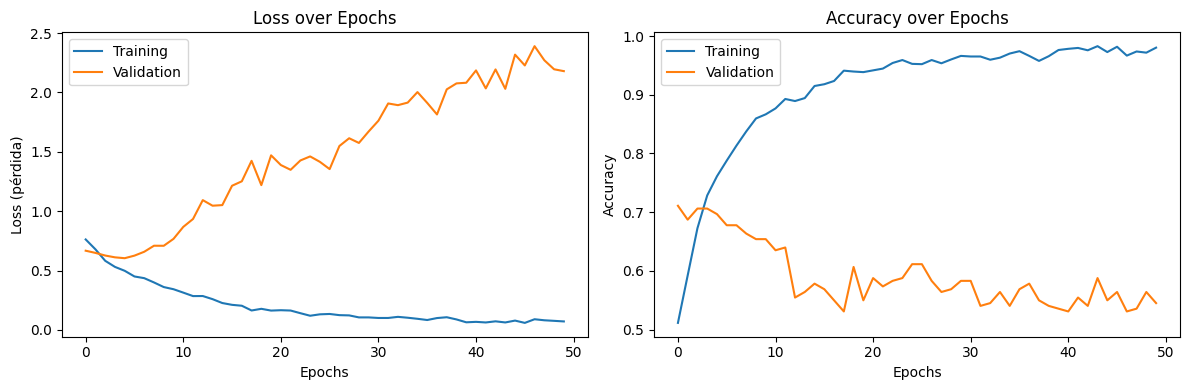

- Accuracy (train): 0.9904


,precision,recall,f1-score,support,0,1
0,0.964981,0.997988,0.981207,497.000000,496.0,1.0
1,0.999322,0.987936,0.993596,1492.000000,18.0,1474.0
accuracy,0.990447,0.990447,0.990447,0.990447,,
macro avg,0.982151,0.992962,0.987401,1989.000000,,
weighted avg,0.990741,0.990447,0.990500,1989.000000,,


- Accuracy (validation): 0.5450


,precision,recall,f1-score,support,0,1
0,0.230769,0.245902,0.238095,61.000000,15.0,46.0
1,0.684932,0.666667,0.675676,150.000000,50.0,100.0
accuracy,0.545024,0.545024,0.545024,0.545024,,
macro avg,0.457850,0.456284,0.456885,211.000000,,
weighted avg,0.553633,0.545024,0.549171,211.000000,,


##### **Utilizando Features**

Model initialized successfully.
Model trained successfully.


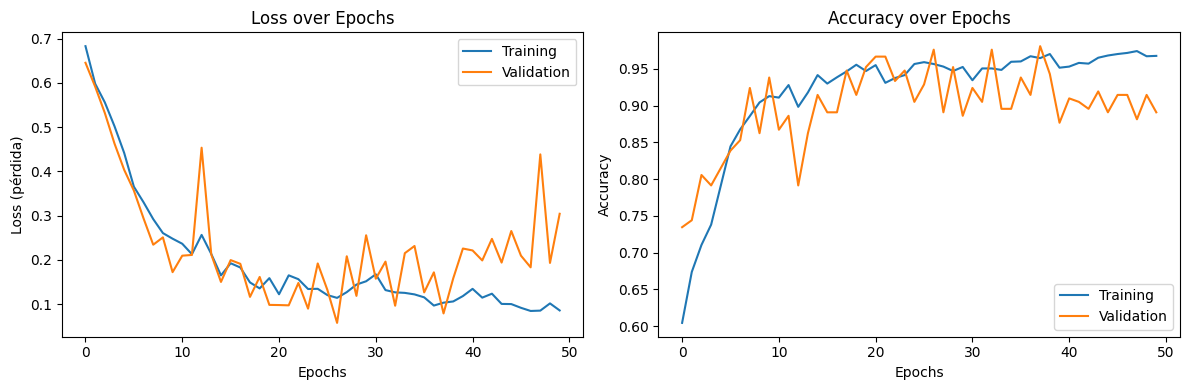

- Accuracy (train): 0.9698


,precision,recall,f1-score,support,0,1
0,0.893694,0.997988,0.942966,497.000000,496.0,1.0
1,0.999303,0.960456,0.979494,1492.000000,59.0,1433.0
accuracy,0.969834,0.969834,0.969834,0.969834,,
macro avg,0.946498,0.979222,0.961230,1989.000000,,
weighted avg,0.972914,0.969834,0.970367,1989.000000,,


- Accuracy (validation): 0.8910


,precision,recall,f1-score,support,0,1
0,0.726190,1.000000,0.841379,61.000000,61.0,0.0
1,1.000000,0.846667,0.916968,150.000000,23.0,127.0
accuracy,0.890995,0.890995,0.890995,0.890995,,
macro avg,0.863095,0.923333,0.879173,211.000000,,
weighted avg,0.920842,0.890995,0.895115,211.000000,,


In [24]:
run_model(mango_dnn, batch_size=64, epochs=50, class_weight=class_weight)

##### Prueba #2

##### **Utilizando PCA**

Model initialized successfully.
Model trained successfully.


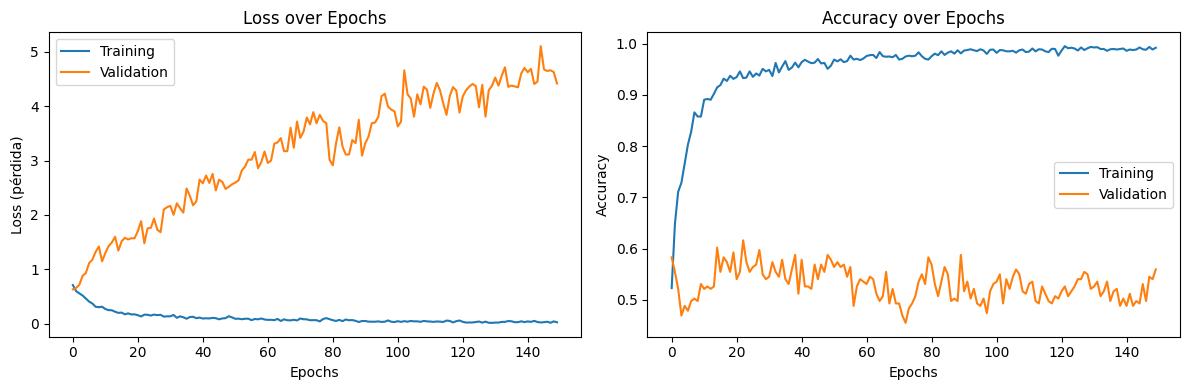

- Accuracy (train): 0.9995


,precision,recall,f1-score,support,0,1
0,0.997992,1.000000,0.998995,497.000000,497.0,0.0
1,1.000000,0.999330,0.999665,1492.000000,1.0,1491.0
accuracy,0.999497,0.999497,0.999497,0.999497,,
macro avg,0.998996,0.999665,0.999330,1989.000000,,
weighted avg,0.999498,0.999497,0.999497,1989.000000,,


- Accuracy (validation): 0.5592


,precision,recall,f1-score,support,0,1
0,0.264706,0.295082,0.279070,61.000000,18.0,43.0
1,0.699301,0.666667,0.682594,150.000000,50.0,100.0
accuracy,0.559242,0.559242,0.559242,0.559242,,
macro avg,0.482003,0.480874,0.480832,211.000000,,
weighted avg,0.573660,0.559242,0.565935,211.000000,,


##### **Utilizando Features**

Model initialized successfully.
Model trained successfully.


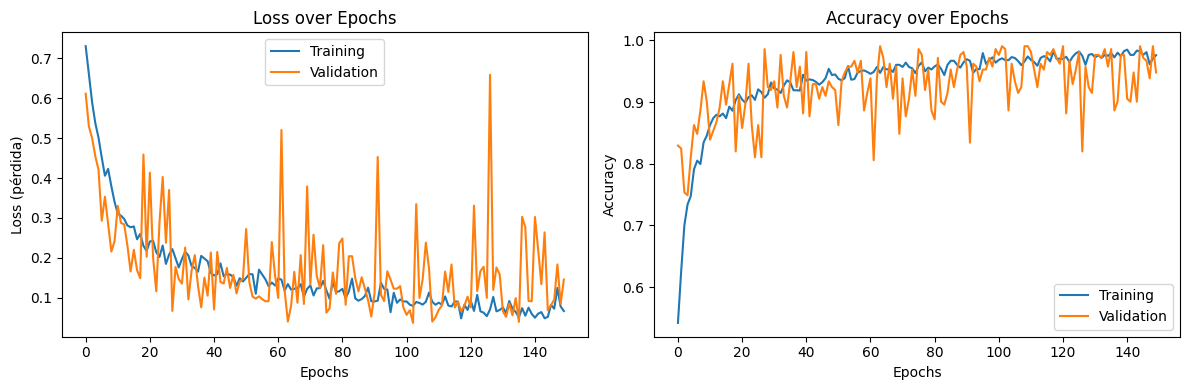

- Accuracy (train): 0.9930


,precision,recall,f1-score,support,0,1
0,0.972603,1.000000,0.986111,497.000000,497.0,0.0
1,1.000000,0.990617,0.995286,1492.000000,14.0,1478.0
accuracy,0.992961,0.992961,0.992961,0.992961,,
macro avg,0.986301,0.995308,0.990699,1989.000000,,
weighted avg,0.993154,0.992961,0.992994,1989.000000,,


- Accuracy (validation): 0.9479


,precision,recall,f1-score,support,0,1
0,0.857143,0.983607,0.916031,61.000000,60.0,1.0
1,0.992908,0.933333,0.962199,150.000000,10.0,140.0
accuracy,0.947867,0.947867,0.947867,0.947867,,
macro avg,0.925025,0.958470,0.939115,211.000000,,
weighted avg,0.953658,0.947867,0.948852,211.000000,,


In [33]:
run_model(mango_dnn, batch_size=16, epochs=150, class_weight=class_weight)

##### Prueba #3

##### **Utilizando PCA**

Model initialized successfully.
Model trained successfully.


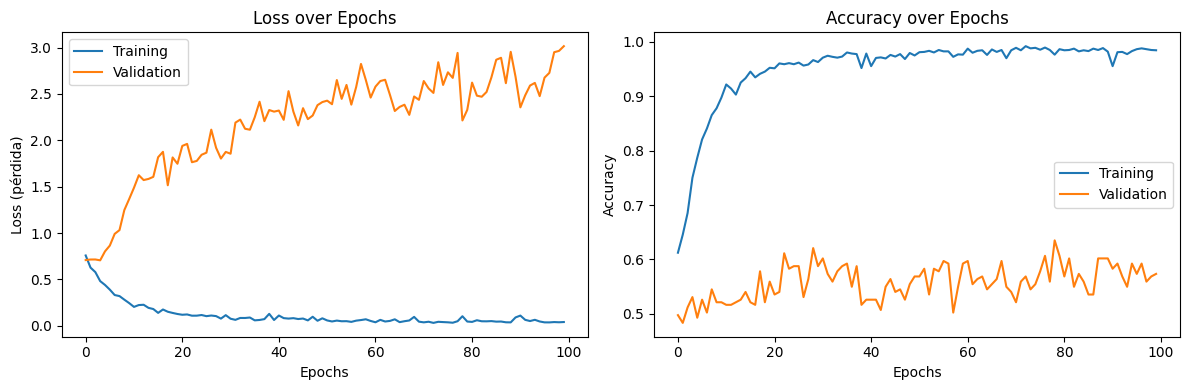

- Accuracy (train): 0.9980


,precision,recall,f1-score,support,0,1
0,0.992016,1.000000,0.995992,497.000000,497.0,0.0
1,1.000000,0.997319,0.998658,1492.000000,4.0,1488.0
accuracy,0.997989,0.997989,0.997989,0.997989,,
macro avg,0.996008,0.998660,0.997325,1989.000000,,
weighted avg,0.998005,0.997989,0.997992,1989.000000,,


- Accuracy (validation): 0.5735


,precision,recall,f1-score,support,0,1
0,0.245614,0.229508,0.237288,61.00000,14.0,47.0
1,0.694805,0.713333,0.703947,150.00000,43.0,107.0
accuracy,0.573460,0.573460,0.573460,0.57346,,
macro avg,0.470210,0.471421,0.470618,211.00000,,
weighted avg,0.564944,0.573460,0.569036,211.00000,,


##### **Utilizando Features**

Model initialized successfully.
Model trained successfully.


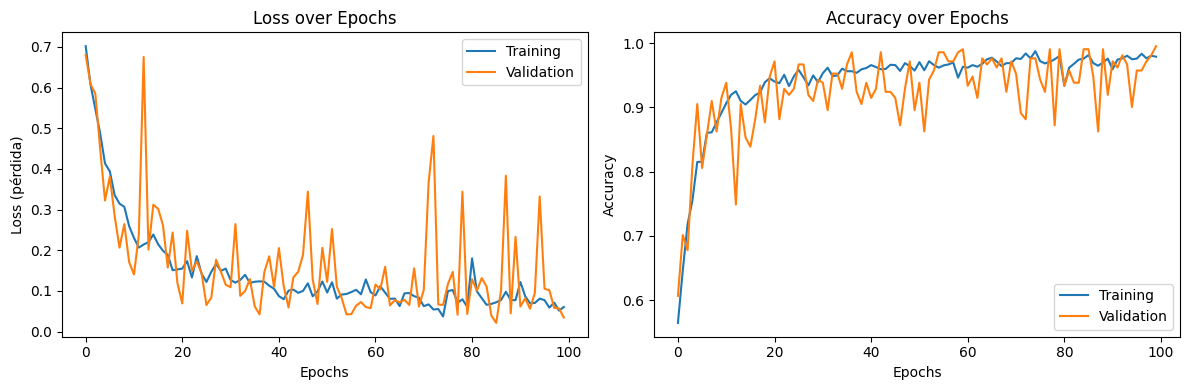

- Accuracy (train): 0.9975


,precision,recall,f1-score,support,0,1
0,0.992000,0.997988,0.994985,497.000000,496.0,1.0
1,0.999328,0.997319,0.998323,1492.000000,4.0,1488.0
accuracy,0.997486,0.997486,0.997486,0.997486,,
macro avg,0.995664,0.997653,0.996654,1989.000000,,
weighted avg,0.997497,0.997486,0.997489,1989.000000,,


- Accuracy (validation): 0.9953


,precision,recall,f1-score,support,0,1
0,1.000000,0.983607,0.991736,61.000000,60.0,1.0
1,0.993377,1.000000,0.996678,150.000000,0.0,150.0
accuracy,0.995261,0.995261,0.995261,0.995261,,
macro avg,0.996689,0.991803,0.994207,211.000000,,
weighted avg,0.995292,0.995261,0.995249,211.000000,,


In [46]:
run_model(mango_dnn, batch_size=32, epochs=100, class_weight=class_weight)

### **Análisis de resultados**

In [47]:
result_df = pd.DataFrame(result)
print(
    f"Se realizaron {result_df.shape[0]} pruebas de diferentes modelos \
para 2 tipos de datos: con PCA y con features. "
)

Se realizaron 20 pruebas de diferentes modelos para 2 tipos de datos: con PCA y con features. 


En esta sección, evaluamos el rendimiento de los modelos utilizando **accuracy** y una **matriz de confusión**. La **accuracy** mide la proporción de predicciones correctas, pero en conjuntos de datos desbalanceados puede no reflejar adecuadamente el rendimiento del modelo. Esto se debe a que un modelo podría predecir siempre la clase mayoritaria y aún así obtener una alta precisión sin realmente capturar bien las clases menos representadas.

Por esta razón, además de la **accuracy**, se consideran otras métricas, tales como:

- **Precisión**: Es la proporción de predicciones positivas correctas. Mide cuántos de los elementos clasificados como positivos realmente lo son. Se observa que la precisión es mayor en la clase Ripe, lo cual podría explicarse por la menor cantidad de datos de validación para esta etiqueta.
  
- **Recall**: Representa la proporción de casos positivos reales que han sido correctamente identificados. Mide la capacidad del modelo para detectar todas las instancias de cada clase. Se observa un mayor recall en los modelos para la clase Rotten, lo que sugiere que, a pesar de aplicar un balanceo mediante la asignación de pesos a cada clase, sigue existiendo un pequeño desbalance en las predicciones.

- **Puntuación F1**: Es el promedio armónico entre precisión y recall, y es especialmente útil para equilibrar el rendimiento entre las clases, especialmente en situaciones de datos desbalanceados. Dado que existe un sesgo en la precisión hacia la clase Ripe y un sesgo en el recall hacia la clase Rotten, el score-F1 resulta similar en ambos modelos, lo cual indica que las métricas de precisión y recall están relativamente equilibradas.

Estas métricas proporcionan una evaluación más completa del modelo, especialmente en escenarios de desbalance entre las clases, permitiendo una visión más precisa del rendimiento general del modelo.

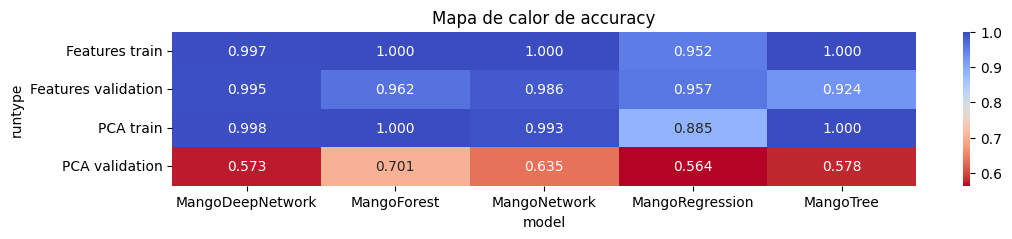

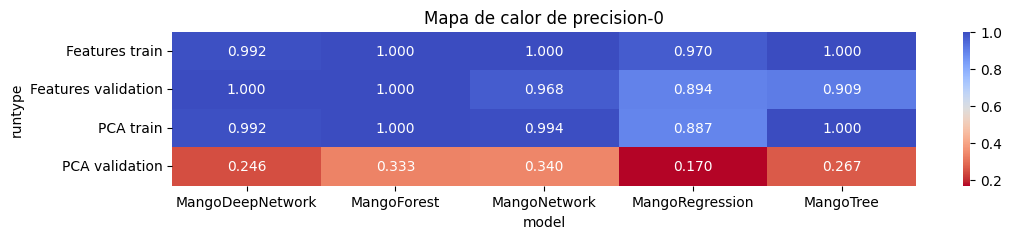

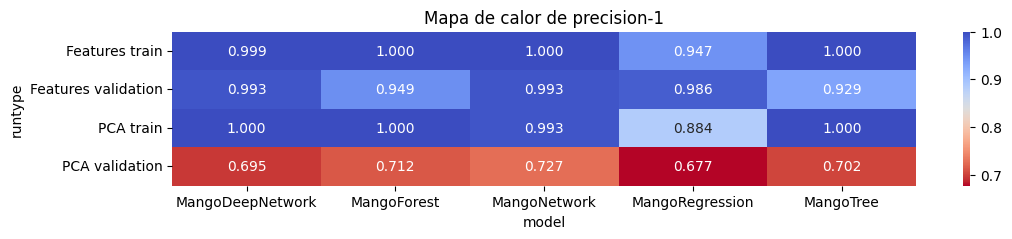

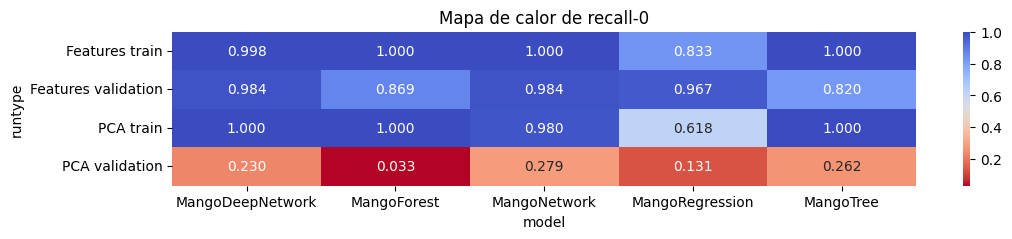

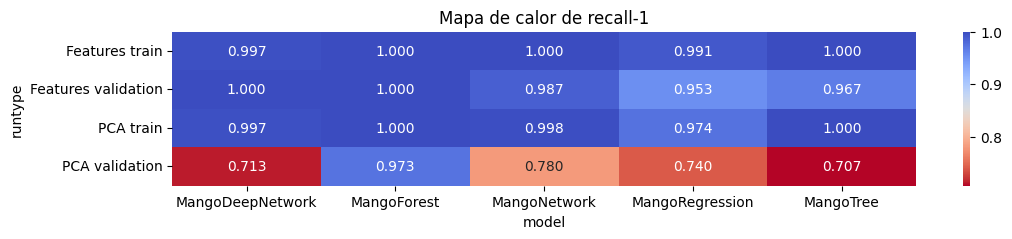

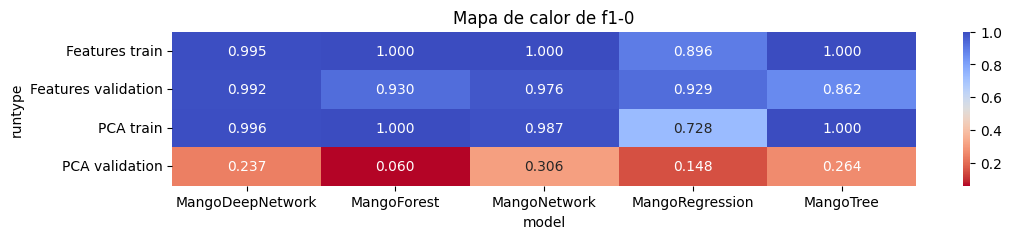

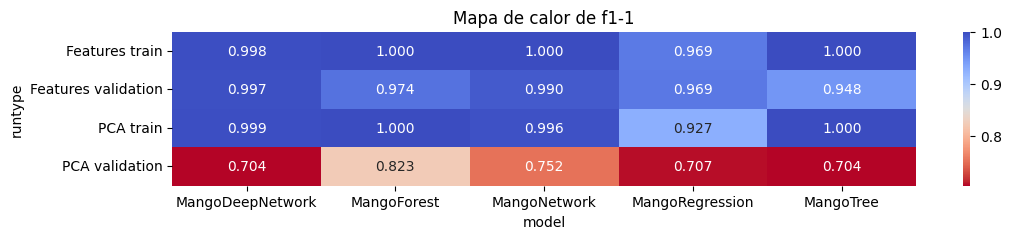

In [48]:
for heatmap_label in [
    "accuracy",
    "precision-0",
    "precision-1",
    "recall-0",
    "recall-1",
    "f1-0",
    "f1-1",
]:
    graphic.show_results_heatmap(result_df, label=heatmap_label)

##### Tasa de aciertos por tipo de validación

La matriz de confusión revela que los modelos alcanzan una alta precisión al identificar mangos Rotten, pero en ocasiones tienen dificultades con los mangos Ripe. Esta discrepancia indica posibles problemas con la diferenciación de características o el desequilibrio de clases en los datos de entrenamiento.

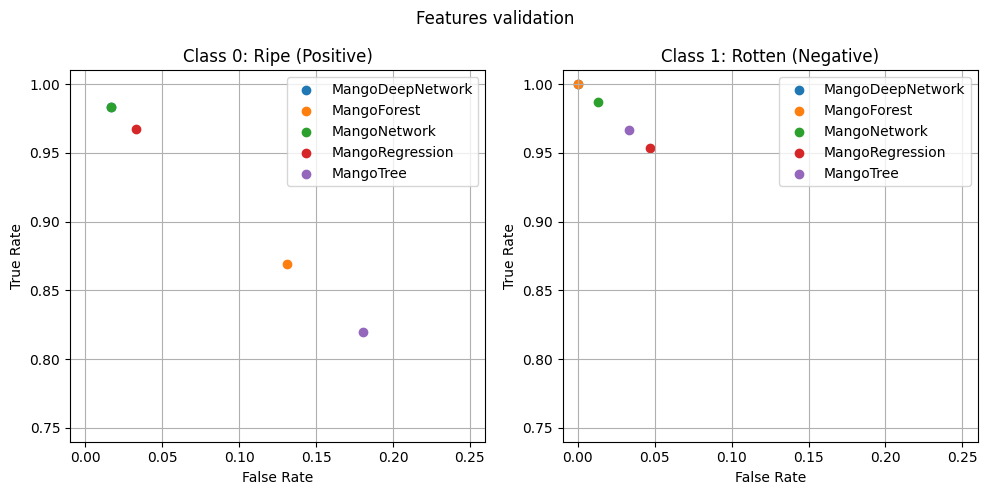

In [71]:
graphic.show_scattered_cm(result_df, "Features validation")

### **Conclusiones**

Los resultados obtenidos en este análisis destacan la efectividad de las redes neuronales MLP y profundas para abordar problemas complejos de clasificación de imágenes, superando en rendimiento a métodos más simples como los árboles de decisión o la regresión multivariada. Sin embargo, se observó que el rendimiento de los modelos depende de la cantidad de características y el tamaño del conjunto de datos, lo que introduce variabilidad en los resultados. En este contexto, los métodos simples mostraron limitaciones al no poder capturar relaciones no lineales o complejas inherentes a los datos de imagen.

Los resultados fueron el fruto de un preprocesamiento cuidadoso, que incluyó la extracción de características relevantes, el escalado de valores, la reducción de dimensionalidad mediante Análisis de Componentes Principales (PCA) —aunque sin una mejora significativa en el rendimiento— y la optimización de hiperparámetros mediante **GridSearch**.

Un factor importante fue el desbalance en el conjunto de datos, donde la clase dominante *Rotten* mostró una precisión significativamente alta, mientras que la clase minoritaria *Ripe* obtuvo un rendimiento más bajo. Esto subraya la necesidad de aplicar estrategias para manejar el desbalance, como técnicas de sobre-muestreo o ponderación de clases, para mejorar el rendimiento en las clases minoritarias.

#### Desempeño de los Modelos

El análisis de los modelos de clasificación reveló un desempeño variable según el modelo y las características utilizadas:

- **Regresión Multivariada**  
  La regresión multivariada alcanzó un **accuracy** de **95%** en la validación, un desempeño adecuado pero limitado en cuanto a la capacidad para modelar relaciones no lineales. La precisión de entrenamiento fue similar a la de validación, lo que sugiere que no hubo overfitting. No obstante, su simplicidad lo hace inapropiado para problemas de clasificación complejos como este.

- **Árboles de Decisión**  
  Los árboles de decisión tuvieron un rendimiento inferior, con un **accuracy** de **92%** en validación. Este modelo mostró mayor propensidad al overfitting, evidenciada por una discrepancia moderada entre las precisiones de entrenamiento y validación. Aunque es sencillo de implementar, no logró capturar adecuadamente la complejidad de los datos de alta dimensionalidad.

- **Random Forest**  
  El modelo de **Random Forest**, al combinar múltiples árboles de decisión, alcanzó un **accuracy** de **97%** en la validación. Este rendimiento superior se atribuye a la capacidad del modelo para mitigar el overfitting, aprovechando la diversidad de los árboles individuales para mejorar la generalización. Aunque su costo computacional fue mayor que el de los modelos más simples, su rendimiento robusto lo convierte en una opción sólida.

- **Red Neuronal MLP**  
  El modelo de **Red Neuronal MLP** alcanzó un **accuracy** de **98%**, pero mostró limitaciones al no capturar las relaciones complejas de los datos tan eficazmente como las redes neuronales profundas. La menor capacidad del perceptrón multicapa para modelar representaciones complejas resultó en un rendimiento máximo algo inferior en comparación con modelos más complejos.

- **Red Neuronal Profunda DNN**  
  El modelo DNN mostró un desempeño notable, con un **accuracy** entre **95%** y **99%** durante los epochs de validación. Sin embargo, su rendimiento oscilante refleja la sensibilidad a la cantidad de datos disponibles y la falta de un ajuste fino de los hiperparámetros mediante **GridSearch**. Aunque las redes profundas tienen la capacidad de capturar relaciones complejas, su mayor profundidad puede generar inestabilidad en conjuntos de datos pequeños. Esto resalta la necesidad de un balance adecuado entre la arquitectura del modelo y su optimización para evitar sobreajuste y mejorar la generalización.

#### **Desafíos y Propuestas para Futuras Implementaciones**

Durante el desarrollo del proyecto, se identificaron varios desafíos técnicos que afectaron el desempeño y la generalización de los modelos:

- **Costo Computacional**  
  Las redes neuronales profundas y MLP resultaron ser altamente demandantes en términos de recursos computacionales, duplicando o triplicando los tiempos de procesamiento de otros modelos como Random Forest. Este costo computacional debe considerarse en futuras implementaciones, especialmente cuando se manejan grandes volúmenes de datos o se disponen de recursos limitados. Además, el desempeño de DNN podría haberse mejorado aún más implementando GridSearch, pero el costo de recursos aumenta con el número de capas.

- **Variabilidad y Aumento de Datos**  
  La variabilidad en las condiciones de iluminación, los patrones de fondo y los bajos contrastes en las imágenes dificultaron la obtención de resultados consistentes, especialmente para las clases minoritarias. Para mitigar este problema, se recomienda aplicar técnicas de aumento de datos y muestreo para las clases minoritarias, lo que ayudaría a balancear el conjunto de datos. Además, diversificar las condiciones de las imágenes, como variaciones en los fondos y mejoras en el contraste, podría fortalecer la capacidad del modelo para generalizar en diferentes escenarios.

- **Exploración de Modelos Avanzados**  
  Las **Redes Neuronales Convolutivas (CNN)** representan una opción prometedora para abordar problemas de clasificación de imágenes debido a su capacidad para aprender representaciones espaciales complejas. Las CNN son especialmente eficaces para tareas de visión por computadora, donde la estructura espacial de los datos es crucial. Su capacidad para extraer características jerárquicas de las imágenes podría mejorar significativamente el rendimiento en tareas de clasificación de imágenes.

En conclusión, para mejorar los resultados en los modelos de aprendizaje supervisado de clasificación de imágenes es clave personalizar los enfoques, equilibrando la complejidad del modelo y la cantidad de datos. Es importante evitar la falta de datos y el overfitting, y explorar métodos híbridos como redes neuronales convolutivas combinadas con aprendizaje profundo. La optimización dependerá de ajustar parámetros, arquitecturas y explorar nuevas estrategias de preprocesamiento y aumento de datos.